# CNN on CIFAR10

In [96]:
import torch
import torchvision
import torchsummary
import numpy as np
import seaborn as sn
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

## General Constants

In [97]:
BATCH_SIZE = 200
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
LEARNING_RATE = 0.001
N_EPOCHS = 30
PATH = '.cifar_model.pth'
TRAIN_VAL_SPLIT = [45000, 5000]

## Loading the data

In [98]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform,
)

train_set, val_set = torch.utils.data.random_split(train_set, TRAIN_VAL_SPLIT)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Files already downloaded and verified
Files already downloaded and verified


## The Model

In [99]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(
            in_channels=3,
            out_channels=32,
            kernel_size=5,
            padding='same',
            stride=1,
        )
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=7,
            padding='same',
            stride=1,
        )
        self.relu2 = torch.nn.ReLU()
        self.max_pool = torch.nn.MaxPool2d(2)
        self.flatten = torch.nn.Flatten()
        self.dense = torch.nn.Linear(
            in_features=16384,
            out_features=10
        )
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.max_pool(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.softmax(x)
        return x

In [100]:
model = Model()

torchsummary.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]         100,416
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
           Flatten-6                [-1, 16384]               0
            Linear-7                   [-1, 10]         163,850
           Softmax-8                   [-1, 10]               0
Total params: 266,698
Trainable params: 266,698
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.75
Params size (MB): 1.02
Estimated Total Size (MB): 2.78
----------------------------------------------------------------


In [101]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training loop

In [102]:
accuracy_hist = []
loss_hist = []
val_accuracy_hist = []
val_los_hist = []

for epoch in range(N_EPOCHS):
    training_cost = 0.0
    training_correct = 0.0
    validation_cost = 0.0
    validation_correct = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        predictions = model(inputs)
        cost = loss_func(predictions, targets)
        cost.backward()
        optimizer.step()
        training_cost += cost.item()
        training_correct += (torch.argmax(predictions, dim=1) == targets).sum()
    training_cost /= len(train_set)
    training_correct /= len(train_set)
    print(f'epoch: {epoch}, loss: {training_cost}, accuracy: {training_correct}')
    accuracy_hist.append(training_correct)
    loss_hist.append(training_cost)

    with torch.no_grad():
        for inputs, targets in val_loader:
            predictions = model(inputs)
            cost = loss_func(predictions, targets)
            validation_cost += cost.item()
            validation_correct += (torch.argmax(predictions, dim=1) == targets).sum()
        validation_cost /= len(val_set)
        validation_correct /= len(val_set)
        print(f'Validation: loss: {validation_cost}, accuracy: {validation_correct}')
        val_accuracy_hist.append(validation_correct)
        val_los_hist.append(validation_cost)

epoch: 0, loss: 0.010573304621378581, accuracy: 0.3372666537761688
Validation: loss: 0.010241187214851379, accuracy: 0.40639999508857727
epoch: 1, loss: 0.010111172416475083, accuracy: 0.4344666600227356
Validation: loss: 0.01007155430316925, accuracy: 0.4415999948978424
epoch: 2, loss: 0.009910089834531148, accuracy: 0.47504445910453796
Validation: loss: 0.009819216966629029, accuracy: 0.4925999939441681
epoch: 3, loss: 0.009721814897325303, accuracy: 0.513022243976593
Validation: loss: 0.009646803927421569, accuracy: 0.5264000296592712
epoch: 4, loss: 0.009658968554602729, accuracy: 0.5250444412231445
Validation: loss: 0.009678608512878419, accuracy: 0.5174000263214111
epoch: 5, loss: 0.00952887045542399, accuracy: 0.5526221990585327
Validation: loss: 0.009519533658027648, accuracy: 0.5523999929428101
epoch: 6, loss: 0.00949660607708825, accuracy: 0.5587777495384216
Validation: loss: 0.009471375107765198, accuracy: 0.5633999705314636
epoch: 7, loss: 0.009443303857909308, accuracy: 0.

KeyboardInterrupt: 

## Save the trained model

In [103]:
torch.save(model.state_dict(), PATH)

## Viszualizing the training

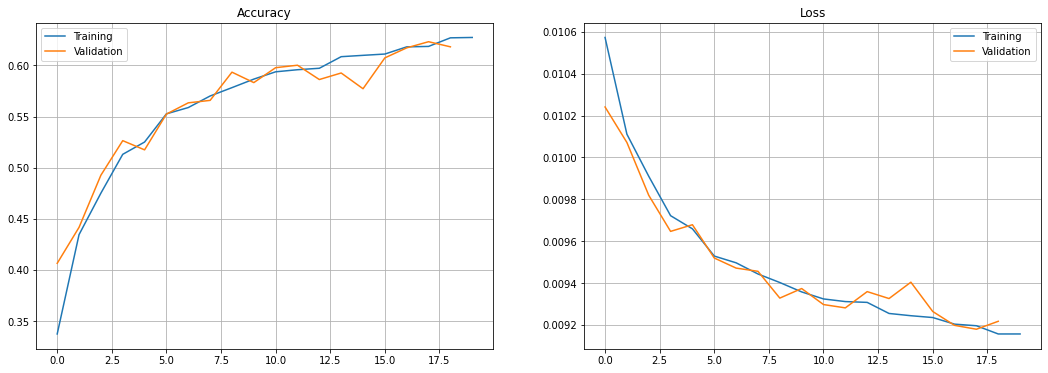

In [104]:
f = plt.figure(figsize=(18, 6))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(accuracy_hist, label='Training')
ax1.plot(val_accuracy_hist, label='Validation')
ax1.title.set_text('Accuracy')
ax1.legend()
ax1.grid()
ax2.plot(loss_hist, label='Training')
ax2.plot(val_los_hist, label='Validation')
ax2.title.set_text('Loss')
ax2.legend()
ax2.grid()

## Load the trained model

In [ ]:
model = Model()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Testing the model

In [105]:
correct = 0

targs = []
preds = []

with torch.no_grad():
    for inputs, targets in test_loader:
        predictions = model(inputs)
        torch.argmax(predictions)
        correct += (torch.argmax(predictions, dim=1) == targets).sum()
        targs.extend(targets)
        preds.extend(torch.argmax(predictions, dim=1))

print(f'Accuracy on training set: {correct / len(test_set)}')

Accuracy on training set: 0.6219000220298767


## Confusion matrix

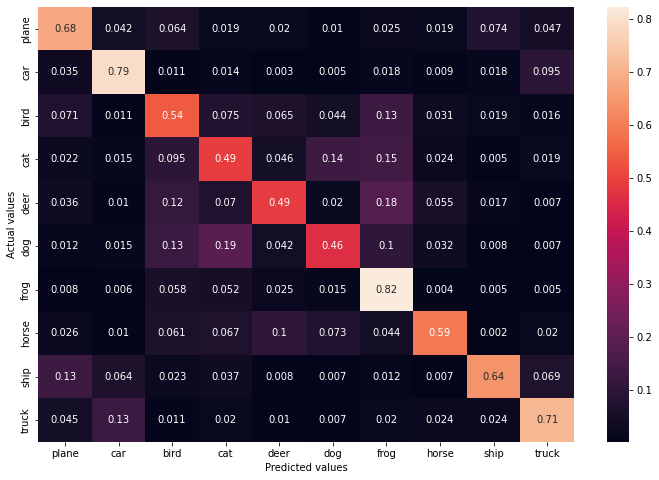

In [106]:
cf_matrix = confusion_matrix(targs, preds)

df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix) * 10, index=[i for i in CLASSES], columns=[i for i in CLASSES])

plt.figure(figsize=(12, 8))
ax = sn.heatmap(df_cm, annot=True)
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')

plt.show()

## Log

|   Model   |   Batch Size  |   Learning Rate   |   Epochs  |   Random Transforms   |   Random Rotations    |   Training Accuracy   |   Test Accuracy   |
|-----------|--------------:|------------------:|----------:|:---------------------:|:---------------------:|----------------------:|------------------:|
|   Layer 1: Conv2d, Layer 2: ReLU, Layer 3: MaxPool2d, Layer 4: Flatten, Layer 5: Linear, Layer 6: Softmax |   300 |   0.001   |   30   |   yes |   yes |   62% |   61% |
|   Layer 1: Conv2d, Layer 2: ReLU, Layer 3: MaxPool2d, Layer 4: Flatten, Layer 5: Linear, Layer 6: Softmax |   300 |   0.001   |   30   |   no |   no |   77% |   64% |
|   Layer 1: Conv2d, Layer 2: ReLU, Layer 3: Conv2d, Layer 4: ReLU, Layer 5: MaxPool2d, Layer 6: Flatten, Layer 7: Linear, Layer 8: Softmax |   200 |   0.001   |   18   |   no |   no |   88% |   67% |
|   Layer 1: Conv2d, Layer 2: ReLU, Layer 3: Conv2d, Layer 4: ReLU, Layer 5: MaxPool2d, Layer 6: Flatten, Layer 7: Linear, Layer 8: Softmax |   200 |   0.001   |   20   |   yes |   yes |   63% |   62% |
|   Layer 1: Conv2d, Layer 2: ReLU, Layer 3: MaxPool2d, Layer 4: Flatten, Layer 5: Linear, Layer 6: Softmax |   200 |   0.001   |   30   |   no |   no |   79% |   65% |

Random transforms and rotations seem to decrease the potential of overfitting, but also the resulting accuracy. Additionally, training time is much higher.